# Biblioteki

In [10]:
import numpy as np
import pandas as pd
import json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = [15, 10]
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, Lasso

import itertools

# Deklaracje

In [11]:
def plot_ts(ts):
    fig, ax = plt.subplots()
    ts_roll_mean = ts.rolling(window=12).mean()
    ts_roll_std = ts.rolling(window=12).std()
    
    ts.plot(color='blue', label='Original', use_index=False)
    ts_roll_mean.plot(color='red', label="Rolling mean", use_index=False)
    ts_roll_std.plot(color='black', label="Rolling std", use_index=False)
    
    ax.set_xticklabels(ts.index)
    fig.autofmt_xdate()
    
    
    plt.xlabel('Date')
    plt.ylabel('Return ratio')
    plt.show()
    
def perform_dft(ts):
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(y_train, autolag='AIC')
    add_col = []
    values = list(dftest[0:4])
    for key,value in dftest[4].items():
        add_col.append('Critical Value (%s)'%key)
        values.append(value)

    dfoutput = pd.DataFrame(data = [values], index=['Wartość'], columns=['Test Statistic','p-value','#Lags Used','Number of Observations Used']+add_col)
    display(dfoutput)

def decompose(ts):
    decomposition = seasonal_decompose(ts, freq=10) 
    decomposition.plot()
    plt.show()
    
def find_best_hparameters(ts, x, pmax, d, qmax):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for p in range(pmax+1):
        for q in range(qmax+1):
            order = (p,d,q)
            try:
                model = SARIMAX(ts, x, order=order, freq='B', trend='c')
                results = model.fit()
                rmse_value = rmse(results.fittedvalues, ts)
                rmse_value_list.append(rmse_value)
                order_list.append(order)
            except Exception as e:
                errors_dict[str(order)] = {'error_str': str(e)}
    
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best10 = tuple(order for order, rmse_value in results[:10])
    return best10, results

# def find_best_extra_vars(ts, x_array, order, n_max=4):
#     errors_dict = {}
#     rmse_value_list = []
#     order_list = []
#     for i in range(2, n_max+1):
#         print(i)
#         try:
#             model = SARIMAX(ts, order=order, freq='B')
#             results = model.fit()
#             rmse_value = rmse(results.fittedvalues, ts)
#             rmse_value_list.append(rmse_value)
#             order_list.append(order)
#         except Exception as e:
#             errors_dict[str(order)] = {'error_str': str(e)}
    
#     errors = pd.DataFrame.from_dict(errors_dict, orient='index')
#     display(errors)
    
#     results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
#     best10 = tuple(order for order, rmse_value in results[:10])
#     return best10, results

def select_best_orders_from_best10(ts, x, best10):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in best10:
        try:
            model = SARIMAX(ts, x, order=order, freq='B', trend='c')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def test_orders(ts, orders):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in orders:
        try:
            model = ARIMA(ts, order=order, freq='B')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def show_est_plot(ts, x_array=None, order=None, zero=False, naiwny=False, label="Wykres"):
    if zero == True:
        z = [0]*len(ts)
        rmse_value = rmse(ts, z)
        plt.plot(ts.index, z, label="Zero", color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    elif naiwny == True:
        rmse_value = rmse(ts[1:], ts.shift()[1:])
        plt.plot(ts[1:].index, ts.shift()[1:], label="Naiwny", color='red')
        plt.plot(ts[1:].index, ts[1:], label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    else:
        model = SARIMAX(ts, x_array, order=order, freq='B', trend='c')
        results = model.fit()
        rmse_value = rmse(results.fittedvalues, ts)
        plt.plot(ts.index, results.fittedvalues, label=label, color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
        

# Wczytanie zbiorów

In [12]:
train = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/train_ekon.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid1_ekon.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid2_ekon.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid3_ekon.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/test_ekon.csv', index_col=0)

train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)

whole = pd.concat([train, val1, val2, val3, test]).fillna(method='bfill')

train1 = train.asfreq('B', method='bfill').fillna(method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill').fillna(method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill').fillna(method='bfill')

val1 = val1.asfreq('B', method='bfill').fillna(method='bfill')
val2 = val2.asfreq('B', method='bfill').fillna(method='bfill')
val3 = val3.asfreq('B', method='bfill').fillna(method='bfill')
test = test.asfreq('B', method='bfill').fillna(method='bfill')

val = pd.concat([val1, val2, val3]).asfreq('B', method='bfill').fillna(method='bfill')


In [13]:
train1["day_of_week"] = train1.index.dayofweek
train1["day_of_year"] = train1.index.dayofweek
train1["week"] = train1.index.week
train1["quarter"] = train1.index.quarter


val["day_of_week"] = val.index.dayofweek
val["day_of_year"] = val.index.dayofweek
val["week"] = val.index.week
val["quarter"] = val.index.quarter


# Wybór hiperparametrów

In [14]:
last_candidates = [
    ['AROONOSC', 'CDLENGULFING', 'CDLSHORTLINE', 'MININDEX', 'SandP'],
    ['AROONOSC', 'CDLENGULFING', 'CDLSHORTLINE', 'MININDEX'],
    ['AROONOSC', 'MININDEX'],
    ['AROONOSC',
   'CDLENGULFING',
   'CDLMATCHINGLOW',
   'CDLSHORTLINE',
   'MININDEX',
   'NasdaqTech_diff_1'],
    ['AROONOSC',
   'CDLENGULFING',
   'CDLMATCHINGLOW',
   'CDLSHORTLINE',
   'MININDEX'],
]

## Trening 1

In [15]:
results_of_e = []
for train_variables in last_candidates:
    X_train1 = train1[train_variables]
    y_train1 = train1['return ratio']
    
    X_val1 = val1[train_variables]
    y_val1 = val1['return ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val1)):
                    trainX = pd.concat([X_train1, X_val1.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train1, y_val1.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train1, X_train1, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val1.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val1)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


0.027701522238420827


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:                        SARIMAX   Log Likelihood                3462.330
Date:                Sun, 14 Apr 2019   AIC                          -6910.660
Time:                        22:46:25   BIC                          -6873.778
Sample:                    07-02-2012   HQIC                         -6896.890
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0001      0.009      0.013      0.990      -0.017       0.017
AROONOSC      -2.26e-05   1.07e-05     -2.119      0.034   -4.35e-05   -1.69e-06
CDLENGULFING -6.041e-05   1.99e-05     -3.035      0.002   -9.94e-05   -2.14e-05
CDLSHORTLINE  2.453e-05   1.89e-05      1.301      0.193   -1.24e-05    6.15e-05
MININDEX      6.125e-06   5.13e-06      1.194      0.233   -3.93e-06    1.62e-05
SandP        -1.295e-06   6.36e-06     -0.204      0.839   -1.38e-05    1.12e-05
sigma2           0.0005   7.15e-06     65.692      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.12   Jarque-Bera (JB):             46604.98
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.027708431965840538


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3462.358
Date:                Sun, 14 Apr 2019   AIC                          -6908.716
Time:                        22:50:32   BIC                          -6866.565
Sample:                    07-02-2012   HQIC                         -6892.978
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0001      0.009      0.013      0.990      -0.017       0.017
AROONOSC      -2.26e-05   1.09e-05     -2.064      0.039   -4.41e-05   -1.14e-06
CDLENGULFING -6.041e-05   2.01e-05     -3.002      0.003   -9.98e-05    -2.1e-05
CDLSHORTLINE  2.453e-05    1.9e-05      1.292      0.196   -1.27e-05    6.18e-05
MININDEX      6.125e-06   5.19e-06      1.180      0.238   -4.05e-06    1.63e-05
SandP        -1.297e-06   6.43e-06     -0.202      0.840   -1.39e-05    1.13e-05
ma.L1            0.0065      0.020      0.330      0.741      -0.032       0.045
sigma2           0.0005   7.25e-06     64.847      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.02   Jarque-Bera (JB):             46883.28
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02770825418168864


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3462.453
Date:                Sun, 14 Apr 2019   AIC                          -6906.907
Time:                        22:55:08   BIC                          -6859.486
Sample:                    07-02-2012   HQIC                         -6889.202
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0001      0.009      0.015      0.988      -0.017       0.018
AROONOSC      -2.26e-05   1.11e-05     -2.043      0.041   -4.43e-05   -9.16e-07
CDLENGULFING -6.041e-05   2.01e-05     -2.999      0.003   -9.99e-05   -2.09e-05
CDLSHORTLINE  2.453e-05    1.9e-05      1.289      0.197   -1.28e-05    6.18e-05
MININDEX      6.122e-06   5.25e-06      1.166      0.244   -4.17e-06    1.64e-05
SandP        -1.309e-06   6.51e-06     -0.201      0.841   -1.41e-05    1.14e-05
ma.L1            0.0041      0.020      0.206      0.837      -0.035       0.043
ma.L2            0.0133      0.026      0.507      0.612      -0.038       0.065
sigma2           0.0005    7.4e-06     63.562      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.43   Jarque-Bera (JB):             47186.69
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02772792307833471


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3464.822
Date:                Sun, 14 Apr 2019   AIC                          -6909.644
Time:                        22:58:57   BIC                          -6856.955
Sample:                    07-02-2012   HQIC                         -6889.972
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.009      0.018      0.986      -0.018       0.019
AROONOSC      -2.26e-05   1.16e-05     -1.953      0.051   -4.53e-05    8.01e-08
CDLENGULFING -6.041e-05   2.02e-05     -2.990      0.003      -0.000   -2.08e-05
CDLSHORTLINE  2.453e-05    1.9e-05      1.294      0.196   -1.26e-05    6.17e-05
MININDEX      6.112e-06   5.55e-06      1.101      0.271   -4.77e-06     1.7e-05
SandP         -1.36e-06   6.88e-06     -0.198      0.843   -1.48e-05    1.21e-05
ma.L1            0.0035      0.020      0.173      0.863      -0.036       0.043
ma.L2            0.0106      0.026      0.408      0.683      -0.040       0.062
ma.L3            0.0555      0.022      2.470      0.014       0.011       0.099
sigma2           0.0005   7.42e-06     63.292      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.75   Jarque-Bera (JB):             47870.77
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.027708457350930207


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3462.363
Date:                Sun, 14 Apr 2019   AIC                          -6908.726
Time:                        23:01:13   BIC                          -6866.574
Sample:                    07-02-2012   HQIC                         -6892.988
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0001      0.009      0.014      0.989      -0.017       0.017
AROONOSC      -2.26e-05   1.09e-05     -2.067      0.039    -4.4e-05   -1.17e-06
CDLENGULFING -6.041e-05   2.01e-05     -3.005      0.003   -9.98e-05    -2.1e-05
CDLSHORTLINE  2.453e-05    1.9e-05      1.293      0.196   -1.26e-05    6.17e-05
MININDEX      6.123e-06   5.18e-06      1.181      0.237   -4.04e-06    1.63e-05
SandP        -1.304e-06   6.42e-06     -0.203      0.839   -1.39e-05    1.13e-05
ar.L1            0.0062      0.020      0.315      0.753      -0.032       0.045
sigma2           0.0005   7.24e-06     64.901      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.02   Jarque-Bera (JB):             46876.18
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02771469787587898


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3463.173
Date:                Sun, 14 Apr 2019   AIC                          -6906.346
Time:                        23:05:53   BIC                          -6853.657
Sample:                    07-02-2012   HQIC                         -6886.674
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0001      0.004      0.032      0.974      -0.008       0.008
AROONOSC      -2.26e-05   1.26e-05     -1.795      0.073   -4.73e-05    2.07e-06
CDLENGULFING -6.041e-05   2.04e-05     -2.959      0.003      -0.000   -2.04e-05
CDLSHORTLINE  2.453e-05    1.9e-05      1.290      0.197   -1.27e-05    6.18e-05
MININDEX      6.102e-06   5.34e-06      1.142      0.253   -4.37e-06    1.66e-05
SandP        -1.409e-06   6.63e-06     -0.212      0.832   -1.44e-05    1.16e-05
ar.L1            0.5623      1.248      0.451      0.652      -1.884       3.008
ma.L1           -0.5582      1.247     -0.448      0.654      -3.003       1.886
ma.L2            0.0109      0.030      0.358      0.721      -0.049       0.070
sigma2           0.0005   7.36e-06     63.858      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.04   Jarque-Bera (JB):             47300.76
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.027727314697770254


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3465.286
Date:                Sun, 14 Apr 2019   AIC                          -6908.572
Time:                        23:10:14   BIC                          -6850.614
Sample:                    07-02-2012   HQIC                         -6886.932
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.008      0.022      0.983      -0.015       0.015
AROONOSC      -2.26e-05   1.19e-05     -1.893      0.058    -4.6e-05    8.03e-07
CDLENGULFING -6.041e-05   2.11e-05     -2.867      0.004      -0.000   -1.91e-05
CDLSHORTLINE  2.453e-05    1.9e-05      1.289      0.197   -1.28e-05    6.18e-05
MININDEX      6.103e-06   5.63e-06      1.085      0.278   -4.92e-06    1.71e-05
SandP        -1.404e-06   6.98e-06     -0.201      0.840   -1.51e-05    1.23e-05
ar.L1            0.1961      0.452      0.434      0.665      -0.690       1.082
ma.L1           -0.1926      0.452     -0.426      0.670      -1.079       0.694
ma.L2            0.0099      0.027      0.373      0.709      -0.042       0.062
ma.L3            0.0528      0.024      2.227      0.026       0.006       0.099
sigma2           0.0005   7.63e-06     61.587      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.68   Jarque-Bera (JB):             47479.86
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.027710908987825772


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3462.467
Date:                Sun, 14 Apr 2019   AIC                          -6906.935
Time:                        23:13:48   BIC                          -6859.515
Sample:                    07-02-2012   HQIC                         -6889.230
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0001      0.009      0.012      0.990      -0.017       0.017
AROONOSC      -2.26e-05   1.11e-05     -2.040      0.041   -4.43e-05   -8.87e-07
CDLENGULFING -6.041e-05   2.01e-05     -3.006      0.003   -9.98e-05    -2.1e-05
CDLSHORTLINE  2.453e-05    1.9e-05      1.292      0.196   -1.27e-05    6.17e-05
MININDEX      6.125e-06   5.26e-06      1.165      0.244   -4.18e-06    1.64e-05
SandP        -1.295e-06   6.51e-06     -0.199      0.842   -1.41e-05    1.15e-05
ar.L1            0.0069      0.020      0.352      0.725      -0.032       0.046
ar.L2            0.0124      0.026      0.476      0.634      -0.039       0.064
sigma2           0.0005   7.36e-06     63.784      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.33   Jarque-Bera (JB):             47272.89
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
sorted(results_of_e, key=lambda x: x[2])

## Trening 2

In [ ]:
results_of_e = []
for train_variables in last_candidates:
    X_train2 = train2[train_variables]
    y_train2 = train2['return ratio']
    
    X_val2 = val2[train_variables]
    y_val2 = val2['return ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val2)):
                    trainX = pd.concat([X_train2, X_val2.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train2, y_val2.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train2, X_train2, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val2.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val2)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

In [ ]:
results_of_e

## Trening 3

In [ ]:
results_of_e = []
for train_variables in last_candidates:
    X_train3 = train3[train_variables]
    y_train3 = train3['return ratio']
    
    X_val3 = val3[train_variables]
    y_val3 = val3['return ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val3)):
                    trainX = pd.concat([X_train3, X_val3.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train3, y_val3.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train3, X_train3, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val3.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val3)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

In [ ]:
results_of_e

# Estymacja na walidacji i teście

## Walidacja

In [17]:
order = (3, 0, 2)
variables =  ['MIN_diff_1', 'MININDEX_diff_1_shift_19']
y_train_base = train1['return ratio']
x_train_base = train1[variables]
y_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')['return ratio']
x_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')[variables]

In [18]:
model = SARIMAX(y_train_base, x_train_base, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:           return ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3453.058
Date:                Sun, 14 Apr 2019   AIC                          -6888.115
Time:                        23:14:51   BIC                          -6840.695
Sample:                    07-02-2012   HQIC                         -6870.410
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0025      0.001      3.299      0.001       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.590      0.010       0.000       0.

In [19]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c', enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(disp=False)
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

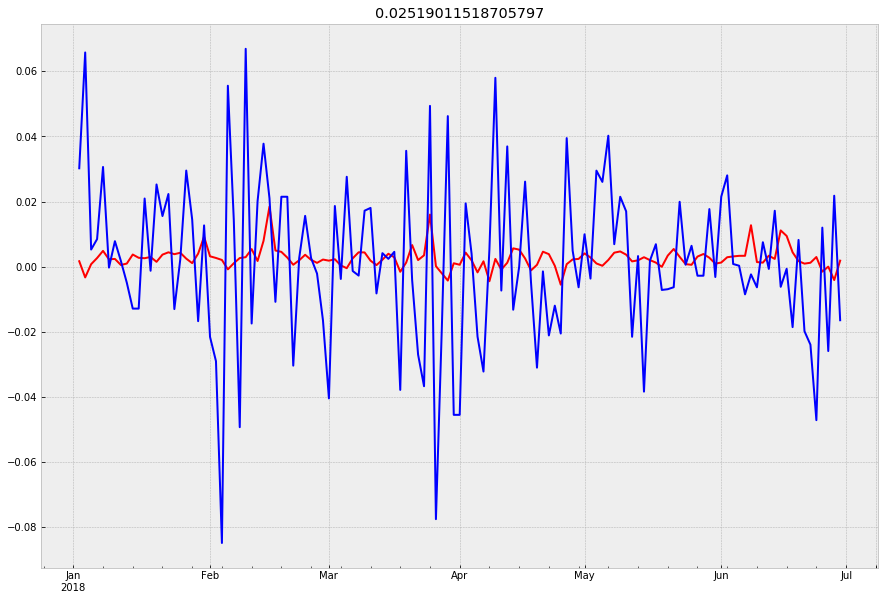

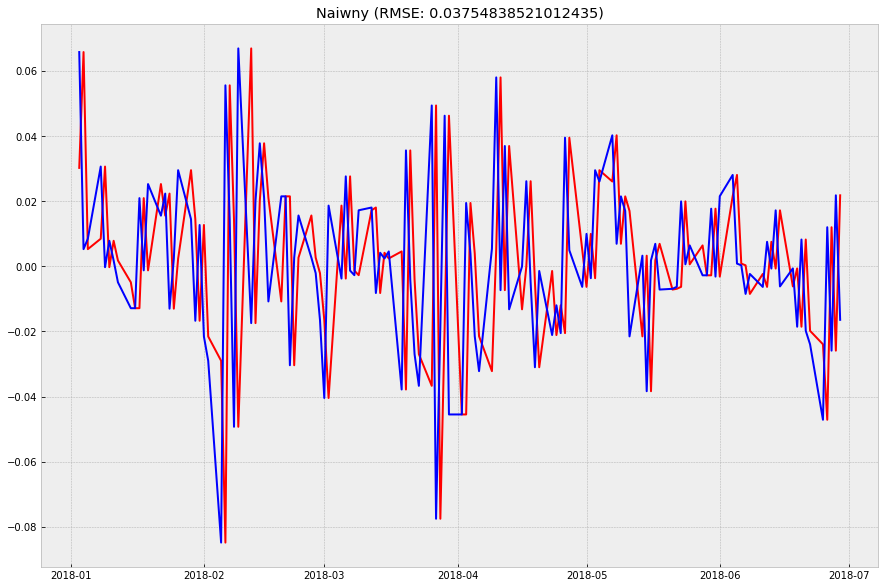

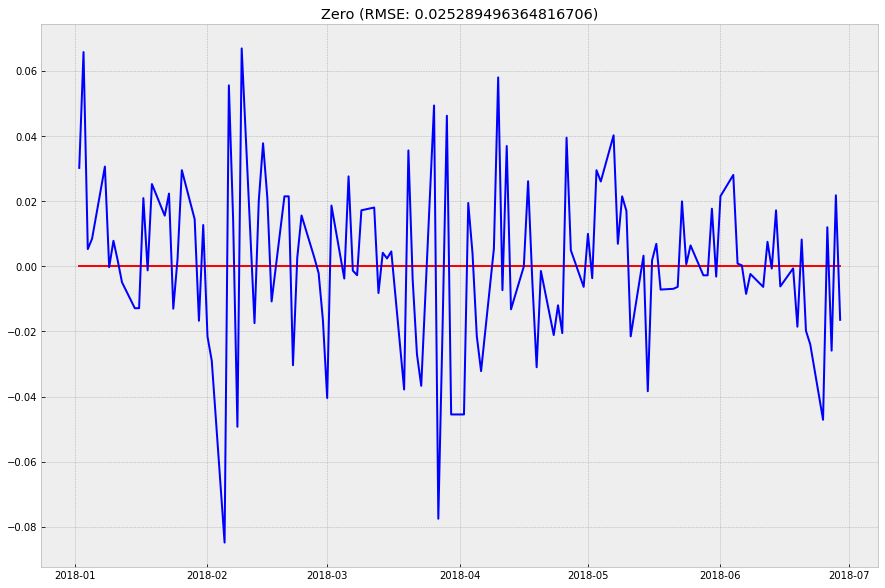

2018-01-02    0.001678
2018-01-03   -0.003290
2018-01-04    0.000774
2018-01-05    0.002662
2018-01-08    0.004867
2018-01-09    0.002275
2018-01-10    0.002391
2018-01-11    0.000532
2018-01-12    0.000963
2018-01-15    0.003739
2018-01-16    0.002738
2018-01-17    0.002607
2018-01-18    0.002987
2018-01-19    0.001498
2018-01-22    0.003705
2018-01-23    0.004422
2018-01-24    0.003846
2018-01-25    0.004283
2018-01-26    0.002476
2018-01-29    0.001091
2018-01-30    0.004013
2018-01-31    0.009227
2018-02-01    0.003198
2018-02-02    0.002685
2018-02-05    0.002069
2018-02-06   -0.000814
2018-02-07    0.001063
2018-02-08    0.002659
2018-02-09    0.002928
2018-02-12    0.005399
2018-02-13    0.001750
2018-02-14    0.007937
2018-02-15    0.018472
2018-02-16    0.004973
2018-02-19    0.004557
2018-02-20    0.002801
2018-02-21    0.000604
2018-02-22    0.001972
2018-02-23    0.003662
2018-02-26    0.002103
2018-02-27    0.001180
2018-02-28    0.002198
2018-03-01    0.001852
2018-03-02 

In [20]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')
print(forecasts)

## Test

In [21]:
order = (3,0,2)
variables = ['MIN_diff_1', 'MININDEX_diff_1_shift_19']
test["week"] = test.index.week
y_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')['return ratio']
x_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')[variables]
y_test_base = test['return ratio']
x_test_base = test[variables]

In [22]:
model = SARIMAX(y_train_base, x_train_base, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:           return ratio   No. Observations:                 1565
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3748.052
Date:                Sun, 14 Apr 2019   AIC                          -7478.104
Time:                        23:24:21   BIC                          -7429.904
Sample:                    07-02-2012   HQIC                         -7460.186
                         - 06-29-2018                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.102      0.002       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.824      0.005       0.000       0.

In [23]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c', enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit()
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

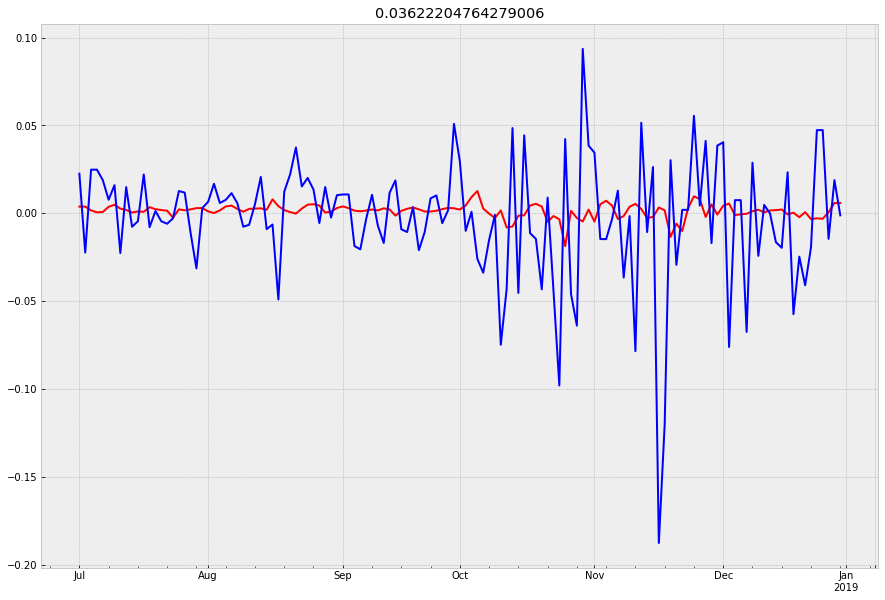

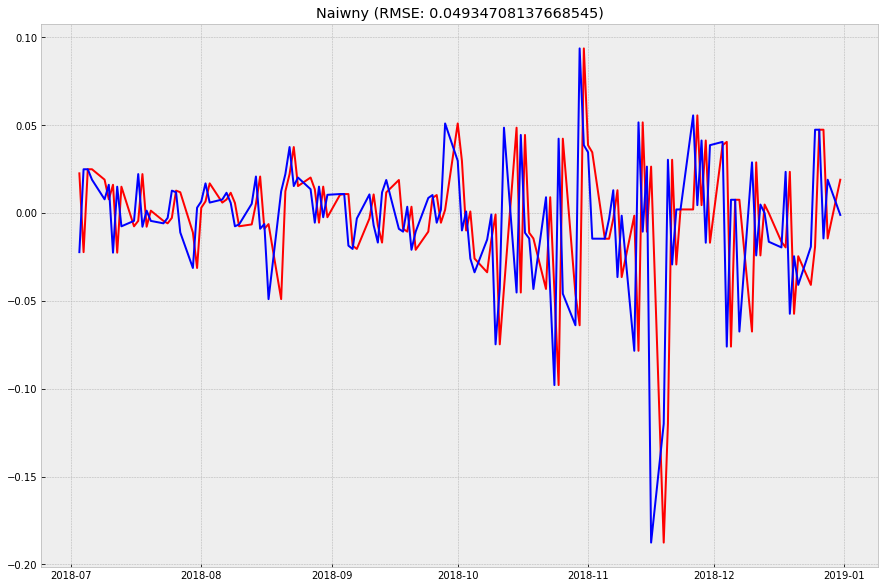

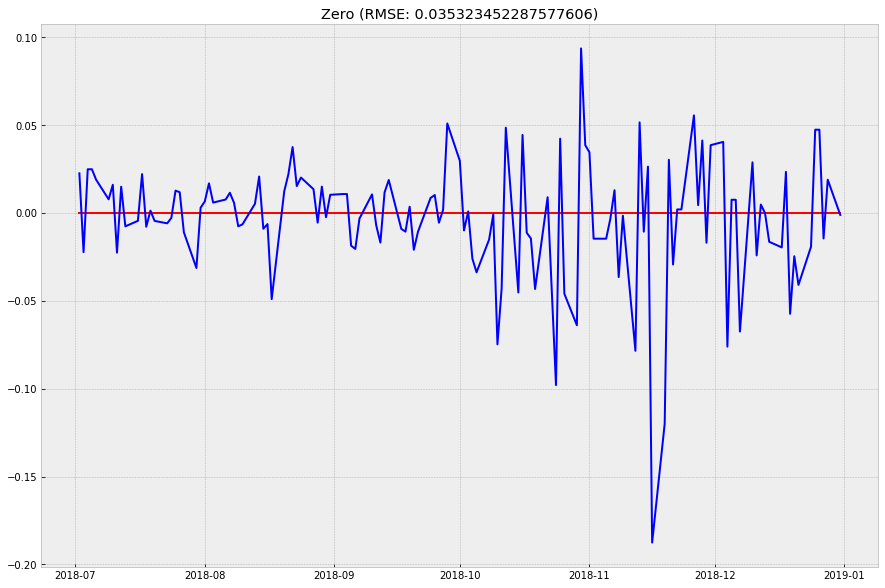

2018-07-02    0.003828
2018-07-03    0.003830
2018-07-04    0.001688
2018-07-05    0.000585
2018-07-06    0.000767
2018-07-09    0.003751
2018-07-10    0.004884
2018-07-11    0.002685
2018-07-12    0.001948
2018-07-13    0.000461
2018-07-16    0.001102
2018-07-17    0.000900
2018-07-18    0.003504
2018-07-19    0.002361
2018-07-20    0.001886
2018-07-23    0.001515
2018-07-24   -0.002465
2018-07-25    0.002252
2018-07-26    0.001752
2018-07-27    0.002278
2018-07-30    0.002979
2018-07-31    0.003020
2018-08-01    0.001134
2018-08-02    0.000193
2018-08-03    0.001686
2018-08-06    0.003912
2018-08-07    0.004415
2018-08-08    0.002516
2018-08-09    0.000930
2018-08-10    0.002548
2018-08-13    0.002704
2018-08-14    0.002865
2018-08-15    0.002078
2018-08-16    0.007959
2018-08-17    0.004138
2018-08-20    0.001857
2018-08-21    0.000741
2018-08-22   -0.000159
2018-08-23    0.002689
2018-08-24    0.004960
2018-08-27    0.005223
2018-08-28    0.004438
2018-08-29    0.000431
2018-08-30 

In [24]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')
print(forecasts)